<a href="https://colab.research.google.com/github/mbargane93/Tweets-Disaster/blob/main/Bootcam_Tweets_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CountVectorizer, Tfidf Vectorizer,  BERT

In [71]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Libraries, Functions and Datasets 

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_style('whitegrid') #  darkgrid

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import feature_extraction
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')


from keras import Input
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from transformers import BertTokenizer, TFBertModel

In [73]:
class Cross_valid:
    def __init__(self,train_data,n_splits):
        self.best_score = 0
        self.best_model = list()
        self.best_model_std = 0
        self.feature_cols = None
        train_data['kfold'] = -1
        kf = KFold(n_splits=n_splits,shuffle=True)
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_data)):
            train_data.loc[valid_idx,'kfold'] = fold
        
        self.data = train_data
        self.n_splits = n_splits
  
    def run_model(self, pipeline_steps, model, feature_cols, target_col, valid_pipeline = False):
        data = self.data.copy()
        current_model_scores = np.array([])
        print(f'Now running the {str(model)} model...\n')
        for fold in range(self.n_splits):
            x_train = data[data['kfold'] != fold][feature_cols].copy()
            x_valid = data[data['kfold'] == fold][feature_cols].copy()
            y_train = data[data['kfold'] != fold][target_col].copy()
            y_valid = data[data['kfold'] == fold][target_col].copy()
            x_train_pipelined = Pipeline(steps=pipeline_steps).fit_transform(x_train)
            x_valid_pipelined = Pipeline(steps=pipeline_steps).transform(x_valid)
                
            model.fit(x_train_pipelined,y_train)
            prediction_valid = model.predict(x_valid_pipelined)
            current_fold_score = f1_score(y_valid,prediction_valid)
            current_model_scores = np.append(current_model_scores,current_fold_score)
            
            print(f'Fold {fold} validation score: {current_fold_score}')
        avg_score = current_model_scores.mean()
        std = current_model_scores.std()
        print(f'Finished running {str(model)} model...\nAverage score: {round(avg_score,5)} \nStandard deviation: {round(std,5)}')
        
        if avg_score > self.best_score:
            self.best_score = avg_score
            self.best_model_std = std
            self.best_model = [pipeline_steps,model]
            self.feature_cols = feature_cols
            print(f'This is the new baseline model! New benchmark value of {round(self.best_score,5)}')
        else:
            print(f'This model failed to beat the benchmark score of {round(self.best_score,5)}...')
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
class Reshaper(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X = X.to_numpy()
        n_size = X[0].shape[0]
        X = X.reshape(-1,1)
        X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, n_size)
        return X
def word_cloud(data,text_column,title=None):

    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in data[text_column]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1500, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image					
    plt.figure(figsize = (15, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 5)
    plt.suptitle(title,fontsize=25,fontweight=100)

    plt.show()
    
    
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

def f1(pred, y):
    score = f1_score(y,pred)
    return 'f1', score

class Text_clearer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X = X.apply(word_tokenize)
        return X
    

# Used the bert encoder and bert model. 

def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)





def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [74]:
test = pd.read_csv('/content/test.csv')
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [76]:
train = pd.read_csv('/content/train.csv')
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [77]:
sample_sub = pd.read_csv('/content/sample_submission.csv')
sample_sub.head(10)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


<h2>exploration</h2>

In [78]:
print('Null values by column on the train dataset:\n')
for column, null_pct in ((train.isna().sum())/(train.shape[0])).items():
    print(f'{round(null_pct*100,2)}% of values on the {column} column are null')

Null values by column on the train dataset:

0.0% of values on the id column are null
0.8% of values on the keyword column are null
33.27% of values on the location column are null
0.0% of values on the text column are null
0.0% of values on the target column are null


In [79]:
print('Null values by column on the test dataset:\n')
for column, null_pct in ((test.isna().sum())/(test.shape[0])).items():
    print(f'{round(null_pct*100,2)}% of values on the {column} column are null')

Null values by column on the test dataset:

0.0% of values on the id column are null
0.8% of values on the keyword column are null
33.86% of values on the location column are null
0.0% of values on the text column are null


In [80]:
print('Disaster tweets occurence of keywords:')
train[train['target'] == 1]['keyword'].value_counts()

Disaster tweets occurence of keywords:


derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: keyword, Length: 220, dtype: int64

In [81]:
print('Non-disaster tweets occurence of keywords:')
train[train['target'] == 0]['keyword'].value_counts()

Non-disaster tweets occurence of keywords:


body%20bags          40
harm                 37
armageddon           37
wrecked              36
ruin                 36
                     ..
typhoon               1
suicide%20bombing     1
suicide%20bomber      1
outbreak              1
oil%20spill           1
Name: keyword, Length: 218, dtype: int64

Text(0.5, 0.98, 'Tweets number(Target)')

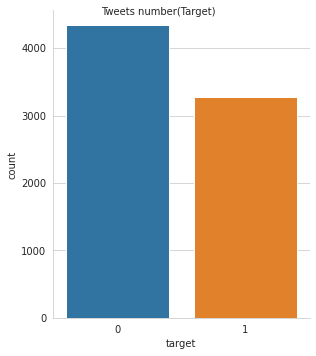

In [82]:
sns.catplot(data=train,kind='count',x='target',aspect=0.9)
plt.suptitle('Tweets number(Target)',fontsize=10,fontweight=80) #point. catplot

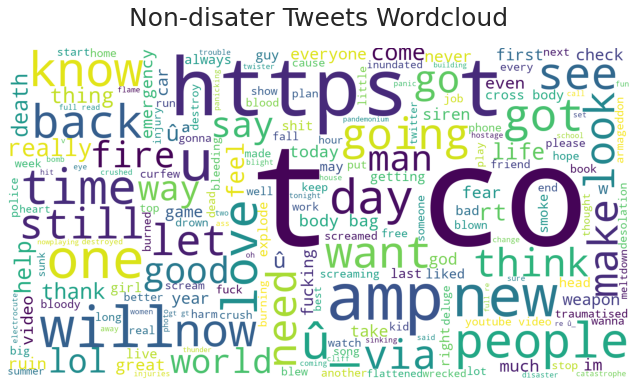

In [83]:
word_cloud(train[train['target'] == 0],'text','Non-disater Tweets Wordcloud')

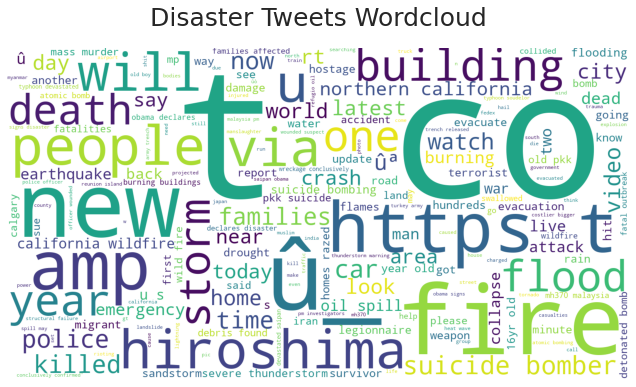

In [84]:
word_cloud(train[train['target'] == 1],'text','Disaster Tweets Wordcloud')

<h2> Testing phase </h2>

<h3> The count Vectorizer with the Logistic Regression </h3>

In [85]:
cv_pipeline = [('cv',feature_extraction.text.CountVectorizer(stop_words='english',max_features=1000,ngram_range=(1,3))),
 ('todense',DenseTransformer())]

nb = GaussianNB()
lr = LogisticRegression()

print('Creating 5-fold cross-validation object...')
five_fold = Cross_valid(train,5)
five_fold.run_model(cv_pipeline,lr,feature_cols = 'text',target_col = 'target')

Creating 5-fold cross-validation object...
Now running the LogisticRegression() model...

Fold 0 validation score: 0.734156378600823
Fold 1 validation score: 0.7467532467532467
Fold 2 validation score: 0.6919275123558484
Fold 3 validation score: 0.7432885906040267
Fold 4 validation score: 0.7351973684210525
Finished running LogisticRegression() model...
Average score: 0.73026 
Standard deviation: 0.01975
This is the new baseline model! New benchmark value of 0.73026


<h3> The count Vectorizer with the Naive Bayes </h3>

In [86]:
five_fold.run_model(cv_pipeline,nb,feature_cols = 'text',target_col = 'target')

Now running the GaussianNB() model...

Fold 0 validation score: 0.4709821428571428
Fold 1 validation score: 0.5258525852585257
Fold 2 validation score: 0.46480446927374297
Fold 3 validation score: 0.49234393404004706
Fold 4 validation score: 0.49427917620137296
Finished running GaussianNB() model...
Average score: 0.48965 
Standard deviation: 0.02147
This model failed to beat the benchmark score of 0.73026...


<h3> The Tfidf with Logistic Regression </h3>

In [87]:
tfidf_pipeline = [('cv',feature_extraction.text.TfidfVectorizer(stop_words='english',max_features=1000,ngram_range=(1,3))),
               ('todense',DenseTransformer())]
five_fold.run_model(tfidf_pipeline,lr,feature_cols = 'text',target_col = 'target')

Now running the LogisticRegression() model...

Fold 0 validation score: 0.7418300653594772
Fold 1 validation score: 0.7440719542109567
Fold 2 validation score: 0.7048242027800491
Fold 3 validation score: 0.7317073170731707
Fold 4 validation score: 0.7339901477832513
Finished running LogisticRegression() model...
Average score: 0.73128 
Standard deviation: 0.01402
This is the new baseline model! New benchmark value of 0.73128


<h3>The  Tfidf with  Naive bayes </h3>

In [88]:
five_fold.run_model(tfidf_pipeline,nb,feature_cols = 'text',target_col = 'target')

Now running the GaussianNB() model...

Fold 0 validation score: 0.44545454545454544
Fold 1 validation score: 0.5044843049327354
Fold 2 validation score: 0.45515695067264567
Fold 3 validation score: 0.480565371024735
Fold 4 validation score: 0.4697674418604651
Finished running GaussianNB() model...
Average score: 0.47109 
Standard deviation: 0.02058
This model failed to beat the benchmark score of 0.73128...


<h3> BERT model</h3>



In [ ]:
# BERT has dozens of pre-trained models but 
# We use the BERT version  : 'bert-base-cased' 

In [89]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

train_input_ids, train_attention_masks = bert_encode(train,60)
test_input_ids, test_attention_masks = bert_encode(test,60)

bert_model = TFBertModel.from_pretrained('bert-base-cased',output_attentions=True)
model = create_model(bert_model)
history = model.fit([train_input_ids,train_attention_masks],train.target,validation_split=0.2, epochs=3,batch_size=50,workers=4,)
y_pred = model.predict([test_input_ids,test_attention_masks])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initia

Epoch 1/3
122/122 [==============================] - 106s 686ms/step - loss: 0.5894 - accuracy: 0.6920 - val_loss: 0.4482 - val_accuracy: 0.8043
Epoch 2/3
122/122 [==============================] - 80s 659ms/step - loss: 0.4463 - accuracy: 0.8123 - val_loss: 0.3974 - val_accuracy: 0.8286
Epoch 3/3
122/122 [==============================] - 80s 658ms/step - loss: 0.3746 - accuracy: 0.8481 - val_loss: 0.3933 - val_accuracy: 0.8286


<h2> Final model, submission file.csv  </h2>

In [90]:
ypred = np.round(y_pred).astype(int)
ypred = pd.DataFrame(ypred)
our_submission = pd.read_csv('/content/sample_submission.csv')
output = pd.DataFrame({'id':our_submission.id,'target':ypred[0]})
output.to_csv('My_submission.csv',index=False)
print('Good!')

Good!


<h1>End <h2>